# SLAM Assignment

The assignment is slightly different than the localization project due to some computational constraints. Unfortunately, SLAM is not fast enough to run in real time on board the Raspberry Pi. Instead, you will implement SLAM to run on some pre-recorded flight data (lists of keypoints, descriptors, and time-of-flight data). Your SLAM will run offline on the data, and you can judge the correctness of your implementation using this notebook to view the animation of the flight.

We provide you here with the animation produced by our solution code for comparison:

<video width=" " height=" " 
       src="../../assets/_images/animation.mp4"  
       controls>
</video>

You should develop your SLAM implementation, using the provided helper code in your project repository. When you want to test your implementation, you should run the cells in this notebook in sequence: first it will run the `map_data.txt` through your SLAM implementation in `student_slam_helper.py` (takes 1-2 minutes to run) and then run the following cells to read from the generated `pose_data.txt` and see your animation. If your animation closely follows that from the solution code, you've done a great job!


In [1]:
# Read, modify and execute the following two cells to load the exercise' code
%load_ext autoreload
%autoreload 2

In [2]:
# TODO: modify <yourGitHubName> to make this the path to your exercise folder
EXERCISE_DIRECTORY = "/code/dd21-slam/packages/project-localization-slam-2019-joshua-8/"
import sys

sys.path.append(EXERCISE_DIRECTORY)

## Exercise

We will provide you with the following files:

- `map_data.txt`
- `student_slam_helper.py`

- `map_data.txt` contains data from a previous flight. It stores keypoints, descriptors, and IR data from each camera frame. The helper code included in slam.py will read the data from map_data, create a FastSLAM object imported from student_slam_helper.py (your code), and run the data through your SLAM implementation.

- `slam_data.txt` will hold data generated by your SLAM implementation including particle poses, landmark poses, and currently observed feature poses. `student_slam_helper.py` will write these data as it runs through the saved flight data with your SLAM implementation. You can use the visualizer in this notebook to view the animation from your SLAM.

You have to implement the missing parts of the `student_slam_helper.py` file, which are indicated with `TODOs`. The intended functionality of each missing method is indicated in the doc strings. You will find that you have already
implemented much of the functionality of SLAM in your localization code.


In [4]:
%%capture

"""
This function reads map data from map_data.txt and plays it through
slam_helper.py

**NOTE**: it can take up to a minute to run
"""

# most amazing and greatest python library
import ast
from student_slam_helper import FastSLAM
import numpy as np

map_path = '/code/dd21-slam/assets/slam_data/map_data.txt'

file = open(map_path, 'r')

map_data = file.readline()
z_data = file.readline()

unprocessed_map_data = ast.literal_eval(map_data)
z_data = ast.literal_eval(z_data)

# chop map_data so same length as z_data
unprocessed_map_data = unprocessed_map_data[0:len(z_data)]

map_data = []
for data in unprocessed_map_data:
    des_list = np.asarray(data[1], dtype=np.uint8)
    map_data.append((data[0], des_list))

slam_estimator = FastSLAM()
slam_estimator.generate_particles(15)

for i in range(1, len(map_data)):
    slam_estimator.run(z_data[i-1], map_data[i-1][0], map_data[i-1][1], map_data[i][0], map_data[i][1])

ModuleNotFoundError: No module named 'student_slam_helper'

In [9]:
import ast

def process_slam_output(path):
    """
    reads the output of student slam implementation formatted as the following:
    line1: particle pose list
    line2: landmark poses list
    line3: current features poses list
    ...
    repeated for every camera frame

    returns a list of x data and y data, formatted like:
    x_data = [[[particle poses], [landmark poses], [feature poses]],
              ...,
              [[particle], [lm], [feat]]]]    <-  one time step
    y_ data is the same
    """
    x_data = []
    y_data = []
    frame_data_x = [[], [], []]
    frame_data_y = [[], [], []]
    count = 0
    
    import itertools
    with open(path, 'r') as f:
        for line1,line2, line3 in itertools.zip_longest(*[f]*3):
            
            try:
                # first line has particle poses
                particle_list = ast.literal_eval(line1)
                frame_data_x[0] = [pair[0] for pair in particle_list]
                frame_data_y[0] = [pair[1] for pair in particle_list]
                
                # second line has landmark poses
                landmark_list = ast.literal_eval(line2)
                frame_data_x[1] = [pair[0] for pair in landmark_list]
                frame_data_y[1] = [pair[1] for pair in landmark_list]
                
                # third line has current features
            
                feature_list = ast.literal_eval(line3)
                frame_data_x[2] = [pair[0] for pair in feature_list]
                frame_data_y[2] = [pair[1] for pair in feature_list]

                x_data.append(frame_data_x)
                y_data.append(frame_data_y)
            except:
                pass
            # append this frame's data and reset frame_data
          
                
            frame_data_x = [[], [], []]
            frame_data_y = [[], [], []]

    return x_data, y_data


x_data, y_data = process_slam_output('/code/dd21-slam/assets/slam_data/pose_data.txt')

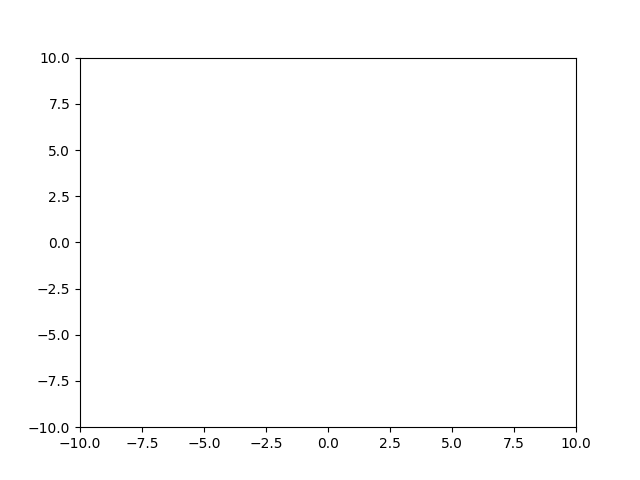

In [10]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# from IPython.display import HTML
import ipywidgets as widgets


%matplotlib widget

fig, ax = plt.subplots()

ax.set_xlim(-10,10)
ax.set_ylim(-10, 10)

labels = ['particles', 'landmarks', 'current features']
colors = ['red', 'grey', 'blue']

def animate(count):
    X = x_data[count]
    Y = y_data[count]

    ax.clear()
    for i, (x, y) in enumerate(zip(X, Y)):
        ax.scatter(x, y, 5, label=labels[i], color=colors[i])
    plt.xlim(-0.25, 0.75)
    plt.ylim(0, 0.6)
    plt.title("DuckieDrone SLAM")
    ax.legend(fontsize='medium')

ani = FuncAnimation(fig, animate, frames=len(x_data),interval=10, blit=False)

plt.show()



## Checkoff

The checkoff for this project is simple, run your `student_slam_helper.py` implementation on the sample data for a TA. Show the TA the corresponding animation.

## On-Board Offline MATL on the Drone

If you try to run your SLAM program offline on the drone, you will find that the program takes up to 15 minutes to run! Instead, we recommend that you use your base station to develop your solution.

After you have implemented your solutions offline, you may optionally
use your solution code to generate maps onboard the drone, then fly the
Duckiedrone to localize it over the map. To do this, you may use a modified version of the
localization code, called MATL (mapping and then localization) which will be provided
to you.

SLAM can run, but it is quite slow on the Raspberry Pi.  We have gotten
it to work on board the Raspberry Pi, but offline.  So you fly, record data,
land, and then make a map and localize.  Details are in the operation
manual, and there are a lot of rough edges. 

# Duckiedrone Instructions


Version 2.0 of the Duckiedrone software comes with 5 programs for vision outlined in the table below. The two main algorithms are Localization and SLAM (Simultaneous Localization and Mapping). They both use the drone’s camera to produce a pose estimate, but localization requires a map of the environment beforehand (`map.jpg`) whereas SLAM builds a map of the environment as it runs. SLAM is much slower than localization. The table shows which of the algorithms are supported under the following conditions: onboard (running on the Raspberry Pi), off board (running on a separate Linux computer), online (running in real time) and offline (collecting data first and then computing in retrospect).

|          | Online              | Offline       |
|----------|---------------------|---------------|
| Onboard  | Localization & SLAM | SLAM          |
| Off board | Localization & SLAM | Not Supported |


**Note** that *SLAM onboard and online is supported, but runs too slow to work accurately*.

Do not expect this program to produce accurate poses.

## SLAM - online

**Offboard:** run `vision_localization_offboard.py` on the Raspberry Pi. On the off board computer run `offboard_slam.py`. Press `r` to toggle SLAM.

**Onboard:** run `vision_localization_onboard.py --SLAM` on the pi. Press `r` to toggle localization.


## SLAM - offline

**Onboard**: run `vision_localization_onboard.py --SLAM --offline` on the Raspberry Pi. Press `m` to toggle mapping mode on, during which you can fly to collect data for the map. Pressing `m` again will stop the mapping and begin running SLAM offline. It is highly recommended that you land the drone for this part. Once it tells you that it is finished making the map, press `r` to toggle localization over the map you have just made.

Happy Flying!